## Feature Engineering : distance
After data preprocessing, I will create a feature to directly describe the distance between the pickup locations and the dropoff locations based 
on their longitude and latitude. Meanwhile, I will also have a  deeper study of the relationship between the ride fare and the locations.


First as usual, I need to import all necessary packages and read the processed training data set.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['font.size']=18

import seaborn as sns
palette = sns.color_palette('Paired',10)

# Any results you write to the current directory are saved as output.

['__output__.json', '__results___files', 'custom.css', 'processed_test.csv', '__results__.html', 'processed_train.csv']


In [2]:
train=pd.read_csv('../input/processed_train.csv',index_col=0)
train.head(5)


/opt/conda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,3
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,5
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,1


Very naively, I created two features named "direct_lat_diff" and "direct_lon_diff" by directly substracting the longitude and latitude of pickup locations from that of dropoff locations. 
Scientifically, this is not a proper way to calculate distance between two locations. But to a certain extent, they still reflect the distances. 

And from the scatter plot below, it can be observed that most rides' both longitude differences and latitude differences are in a range from 0 to 0.5. And there are rides having a very long distance. 

In [3]:
# create absolute distance
train['direct_lat_diff']=(train['dropoff_latitude']-train['pickup_latitude']).abs()
train['direct_lon_diff']=(train['dropoff_longitude']-train['pickup_longitude']).abs()

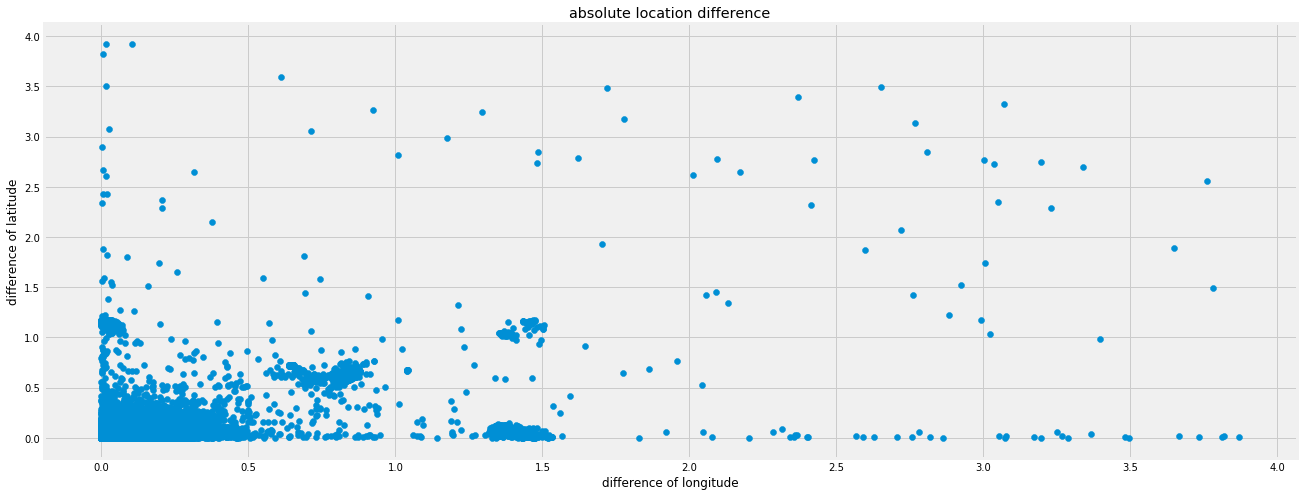

In [5]:
fig,ax=plt.subplots(1,1,figsize=(20,8))
ax.scatter(train['direct_lon_diff'],train['direct_lat_diff'])
ax.set_title("absolute location difference")
ax.set_xlabel("difference of longitude")
ax.set_ylabel("difference of latitude")
plt.show()

Interestingly, there are 103592 rows where the difference both in longitude and latitude are zero. That means the taxi vehicle has not moved at all in those rides.
This is actually a situation happening all the time. An order for the taxi was made, and the taxi arrived. The driver waitted for a very long time but the people who made the order never show up. Thus, we decide not to romove those rows since they are still providing very useful information. 

In [6]:
no_move = train[(train['direct_lon_diff']==0) & (train['direct_lat_diff']==0)]
print(no_move.shape)

(103592, 14)


In the graph below, I colored all the data points based on the fare amount and therefore a heat map was created. Blue means lower price, and correspondingly green means very high price. 
You may see many data points with large longitude or latitude differences having low ride fares. This might reflect the fact that different regions may have different taxi ride rates. And the total ride fare is not only dependent on distances but also largely on the pickup and dropoff locations.

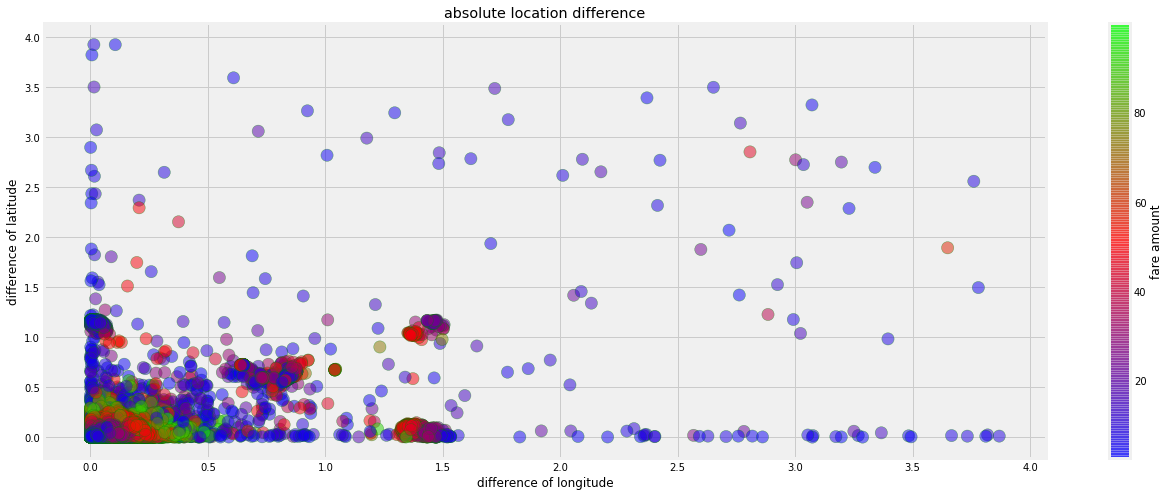

In [7]:
# color the data points according to fare_amount
fig,ax=plt.subplots(1,1,figsize=(20,8))
color = np.array(train['fare_amount'])
cmap=plt.cm.get_cmap("brg")
graph=ax.scatter(train['direct_lon_diff'],train['direct_lat_diff'],alpha=0.5,c=color,cmap=cmap,
                 edgecolors='g',s=150)
cbar = fig.colorbar(graph)
cbar.ax.set_ylabel('fare amount')
plt.title("absolute location difference")
plt.xlabel('difference of longitude')
plt.ylabel("difference of latitude")
plt.show()

If we zoom in this heat map, you may find in the New York City downtown area, the taxi ride fare amount is highly related to the distance. 
In the left lower corner, blue points accmulated together to show a region where the rides have shorter distances and lower fare amounts. In the outer layer, 
there is a huge red region where the rides are in a medium fare range. In the outmost layer, lots of green points with high fare amounts appeared, which formed a high fare region.

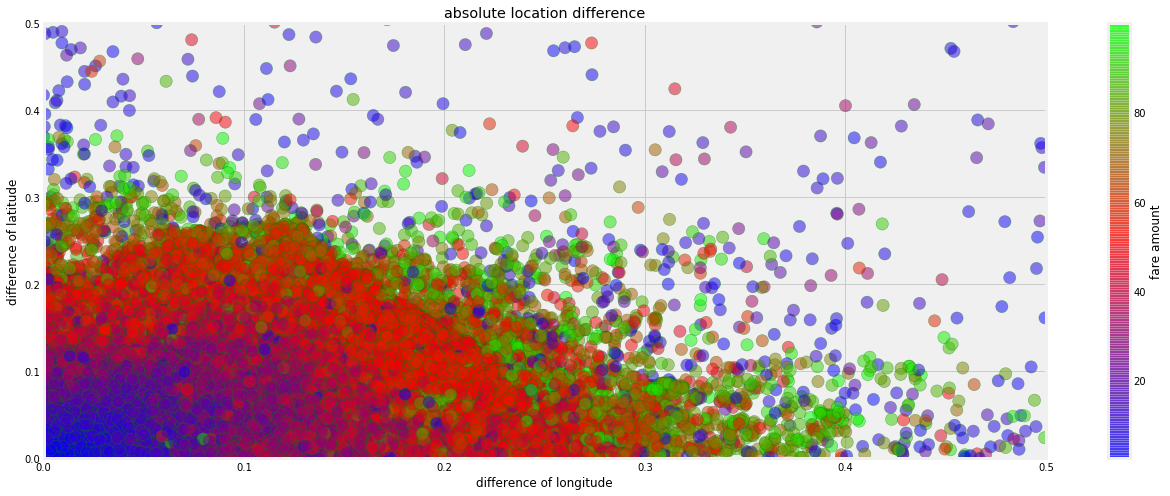

In [9]:
fig,ax=plt.subplots(1,1,figsize=(20,8))
color = np.array(train['fare_amount'])
cmap=plt.cm.get_cmap("brg")
graph=ax.scatter(train['direct_lon_diff'],train['direct_lat_diff'],alpha=0.5,c=color,cmap=cmap,
                 edgecolors='g',s=150)
cbar = fig.colorbar(graph)
cbar.ax.set_ylabel('fare amount')
plt.title("absolute location difference")
plt.xlabel('difference of longitude')
plt.ylabel("difference of latitude")
plt.ylim(0,0.5)
plt.xlim(0,0.5)
plt.show()

Now let's calculate the distance more properly and scientifically. Thank Madhuri Sivalenka very much for her excellent calculation and code about the haversine distance. Basically it calculates the distance in a sphere using longitudes and latitudes. Also refer this page for detailed informtion and explanation on Haversine formula : https://community.esri.com/groups/coordinate-reference-systems/blog/2017/10/05/haversine-formula

haversine(θ) = sin²(θ/2),
a = sin²(φB - φA/2) + cos φA * cos φB * sin²(λB - λA/2),
c = 2 * atan2( √a, √(1−a) ),
d = R ⋅ c,
d = Haversine distance



In [10]:
# we need to create the distance between pickup location and dropoff location
def haversine_distance(lat1,long1,lat2,long2):
    data=[train]
    for item in data:
        R = 6371 #unit is kilometer
        phi1 = np.radians(item[lat1])
        phi2 = np.radians(item[lat2])
        diff_phi1_phi2=np.radians(item[lat2]-item[lat1])
        diff_lambda1_lambda2=np.radians(item[long2]-item[long1])
        
        a = np.sin(diff_phi1_phi2/2.0)**2+np.cos(phi1)*np.cos(phi2)*np.sin(diff_lambda1_lambda2/2.0)**2
        c = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
        d = R*c
        item['Distance'] = d
    return d

haversine_distance('pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude')
train.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,direct_lat_diff,direct_lon_diff,Distance
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0,0.009041,0.002701,1.030764
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1,0.070701,0.036780,8.450134
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,3,0.010708,0.008504,1.389525
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,5,0.024949,0.004437,2.799270
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,1,0.015754,0.011440,1.999157


Afterwards, we put the fare amount into bins and did a kernel density plot to show the distribution of taxi rides' fare amount in 
different fare ranges as a function of the calculated haversine distances.



In [11]:
train['fare-bin'] = pd.cut(train['fare_amount'], bins = list(range(0, 50, 5))).astype(str)

# Uppermost bin
train.loc[train['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'

# Adjust bin so the sorting is correct
train.loc[train['fare-bin'] == '(5, 10]', 'fare-bin'] = '(05, 10]'
train.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,direct_lat_diff,direct_lon_diff,Distance,fare-bin
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,17,0,0.009041,0.002701,1.030764,"(0, 5]"
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,16,1,0.070701,0.036780,8.450134,"(15, 20]"
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,0,3,0.010708,0.008504,1.389525,"(05, 10]"
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,4,5,0.024949,0.004437,2.799270,"(05, 10]"
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,7,1,0.015754,0.011440,1.999157,"(05, 10]"


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


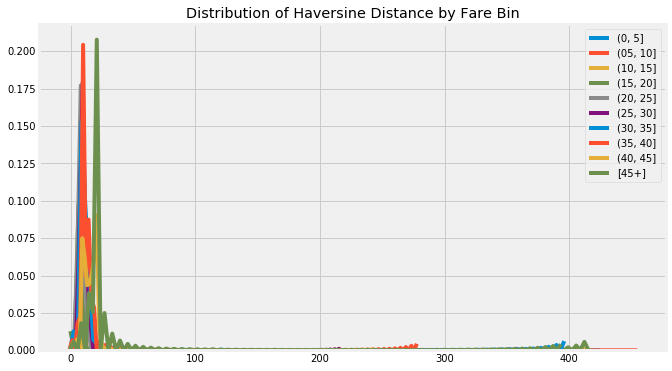

In [12]:
plt.figure(figsize = (10, 6))

for f, grouped in train.groupby('fare-bin'):
    sns.kdeplot(grouped['Distance'], label = f'{f}');
    
plt.title('Distribution of Haversine Distance by Fare Bin');

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


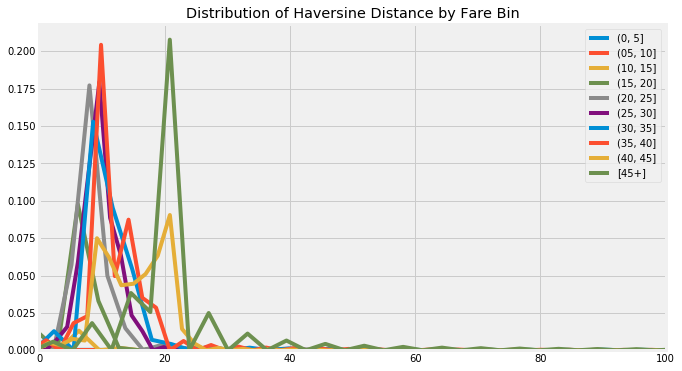

In [13]:
plt.figure(figsize = (10, 6))

for f, grouped in train.groupby('fare-bin'):
    sns.kdeplot(grouped['Distance'], label = f'{f}');

plt.xlim(0,100)
plt.title('Distribution of Haversine Distance by Fare Bin');

If we calculate the average distance of all the taxi rides in each fare amount region, we can plot it as a histogram with 
different fare ranges. Very clearly, there is a increasing trend of average ride distance with the increase of fare amount.

In [14]:
bar = train.groupby('fare-bin')['Distance'].agg(['mean','count'])
print(bar)

               mean    count
fare-bin                    
(0, 5]     0.921987  1512327
(05, 10]   1.945241  4581800
(10, 15]   3.714441  1949497
(15, 20]   5.581388   715430
(20, 25]   7.535295   309967
(25, 30]   9.569034   193605
(30, 35]  10.794055   142389
(35, 40]  11.670751    82741
(40, 45]  14.066546    67912
[45+]     17.627677   197328


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

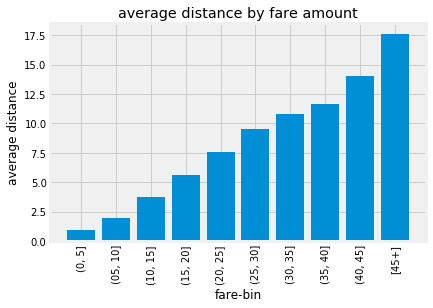

In [15]:
plt.bar(bar.index,height=bar['mean'])
plt.xlabel("fare-bin")
plt.ylabel("average distance")
plt.title("average distance by fare amount")
plt.xticks(rotation=90)

So let's do the same feature engineering to the test set and save it.
Now we are ready to train a model.

In [16]:
test = pd.read_csv("../input/processed_test.csv",index_col=0)
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday
key,,,,,,,,,,,
2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,13,1
2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,13,1
2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,11,5
2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,21,5
2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,21,5


In [17]:
def haversine_distance(lat1,long1,lat2,long2):
    data=[test]
    for item in data:
        R = 6371 #unit is kilometer
        phi1 = np.radians(item[lat1])
        phi2 = np.radians(item[lat2])
        diff_phi1_phi2=np.radians(item[lat2]-item[lat1])
        diff_lambda1_lambda2=np.radians(item[long2]-item[long1])
        
        a = np.sin(diff_phi1_phi2/2.0)**2+np.cos(phi1)*np.cos(phi2)*np.sin(diff_lambda1_lambda2/2.0)**2
        c = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
        d = R*c
        item['Distance'] = d
    return d

haversine_distance('pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude')
test.head(5)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,Distance
key,,,,,,,,,,,,
2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,13,1,2.323260
2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,13,1,2.425353
2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,11,5,0.618628
2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,21,5,1.961033
2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,21,5,5.387301


In [18]:
train.to_csv("finaltrain.csv")
test.to_csv("finaltest.csv")